# Building an end-to-end data pipeline

## By: Ibrahim Noman

In this project, I will be creating a data pipeline that takes in [air quality data](https://aqs.epa.gov/aqsweb/documents/data_api.html#daily) and stores it in SQLite Database. Then, conduct data analysis to derive insight into the air quality index. The goal of this project is to understand how the distribution of air quality looks between two different forms of living: urban and suburban.

## Importing libraries

In [1]:
import requests as rq
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as mp

## Using the requests library we will retrieve the data



*   For api-key and endpoint formatting, visit the air quality data hyperlink above


*   NOTE: this API key has been changed and this chunk won't run






In [2]:
# Formatting the endpoint
endpoint = "https://aqs.epa.gov/data/api/dailyData/byCounty?email=ibrahim.noman788@gmail.com&key=bluegoose83&param=88101&bdate=20240101&edate=20240131&state=48&county=201"

# Using the get function in the requests library
response = rq.get(endpoint)

# catching errors
if response.status_code == 200:
    data = response.json()
else:
    print(f"Error: {response.status_code}")

## Data Cleaning

To perform analysis, we will first need to:



*   Convert our data into a Pandas df
*   Select useful columns



In [3]:
# JSON to Pandas df
json_data = data['Data']
df = pd.DataFrame(json_data)

# Selecting columns
df_sub = df[['county', 'city', 'local_site_name', 'date_local', 'sample_duration', 'parameter', 'poc', 'observation_count',
       'observation_percent', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi']]

df_sub.head(10)

,county,city,local_site_name,date_local,sample_duration,parameter,poc,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
0,Harris,Houston,Houston Bayland Park,2024-01-01,1 HOUR,PM2.5 - Local Conditions,1,24,100.0,68.891667,415.0,0,NaN
1,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
2,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
3,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
4,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
5,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
6,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
7,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
8,Harris,Houston,Houston Bayland Park,2024-01-01,24-HR BLK AVG,PM2.5 - Local Conditions,1,1,100.0,68.800000,68.8,0,160.0
9,Harris,Houston,Houston Bayland Park,2024-01-02,1 HOUR,PM2.5 - Local Conditions,1,22,92.0,10.113636,15.2,14,NaN


## Data Storage

The steps that we will take to store our data are:



*   Create a database connection using the SQLite Library
*   Define a schema

*   Insert the df into the database
*   Test with a query






In [4]:
# Creating connection
con = sq.connect('air_quality.db')

# Defining Schema
create_table = """
CREATE TABLE IF NOT EXISTS air_quality (
  county TEXT,
  city TEXT,
  local_site_name TEXT,
  date_local TEXT,
  sample_duration REAL,
  parameter TEXT,
  poc REAL,
  observation_count REAL,
  observation_percent REAL,
  arithmetic_mean REAL,
  first_max_value REAL,
  first_max_hour REAL,
  aqi REAL

);
"""

con.execute(create_table)
con.commit()

In [5]:
# Inserting data
df_sub.to_sql('air_quality', con, if_exists = 'replace', index = False)

# Verifying query
query = 'SELECT * FROM air_quality LIMIT 5'
result = pd.read_sql(query, con)
print(result)

   county     city       local_site_name  date_local sample_duration  \
0  Harris  Houston  Houston Bayland Park  2024-01-01          1 HOUR   
1  Harris  Houston  Houston Bayland Park  2024-01-01   24-HR BLK AVG   
2  Harris  Houston  Houston Bayland Park  2024-01-01   24-HR BLK AVG   
3  Harris  Houston  Houston Bayland Park  2024-01-01   24-HR BLK AVG   
4  Harris  Houston  Houston Bayland Park  2024-01-01   24-HR BLK AVG   

                  parameter  poc  observation_count  observation_percent  \
0  PM2.5 - Local Conditions    1                 24                100.0   
1  PM2.5 - Local Conditions    1                  1                100.0   
2  PM2.5 - Local Conditions    1                  1                100.0   
3  PM2.5 - Local Conditions    1                  1                100.0   
4  PM2.5 - Local Conditions    1                  1                100.0   

   arithmetic_mean  first_max_value  first_max_hour    aqi  
0        68.891667            415.0              

In [6]:
# Closing connection
con.close()

## Automated Data Pipeline

To automate all the steps, I will create methods for each objective, and then one master function that runs all of them.

NOTE In the store data function I append the data if the table already exists.


In [7]:
# Retrieving data
def extract_data(endpoint):
  response = rq.get(endpoint)
  if response.status_code == 200:
    data = response.json()
  else:
    print(f"Error: {response.status_code}")
    data = None
  return data


# Converting to df
def to_df(data):
  json_data = data['Data']
  df = pd.DataFrame(json_data)
  df_sub = df[['county', 'city', 'local_site_name', 'date_local', 'sample_duration', 'parameter', 'poc', 'observation_count',
       'observation_percent', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi']]
  return df_sub


# Storing data
def store_data(db, df_sub):
  con = sq.connect(db)

  create_table = """
  CREATE TABLE IF NOT EXISTS air_quality (
    county TEXT,
    city TEXT,
    local_site_name TEXT,
    date_local TEXT,
    sample_duration REAL,
    parameter TEXT,
    poc REAL,
    observation_count REAL,
    observation_percent REAL,
    arithmetic_mean REAL,
    first_max_value REAL,
    first_max_hour REAL,
    aqi REAL

  );
  """

  con.execute(create_table)
  con.commit()

  df_sub.to_sql('air_quality', con, if_exists = 'append', index = False)
  con.close()

### Master Function

In [8]:
def run_pipeline(endpoint, db):
  data = extract_data(endpoint)
  if data:
    df_sub = to_df(data)
    store_data(db, df_sub)

# Example endpoint and db
# Let's add data from travis county (county = 453)
endpoint = "https://aqs.epa.gov/data/api/dailyData/byCounty?email=ibrahim.noman788@gmail.com&key=bluegoose83&param=88101&bdate=20240101&edate=20240131&state=48&county=453"
db = 'air_quality.db'

run_pipeline(endpoint, db)

### Testing

From the code below, we can see that now we have data for two counties: Harris and Travis.

In [9]:
# Opening connection
con = sq.connect(db)

query = 'SELECT DISTINCT(county) FROM air_quality'
result = pd.read_sql(query, con)
print(result)

   county
0  Harris
1  Travis


In [10]:
con.close()

## Data  Analysis

Now that we have created a data pipeline, let's analyize our data to see if we can better understand air quality between the two counties.

In [11]:
# Extracting data
db = 'air_quality.db'
con = sq.connect(db)
query = 'SELECT * FROM air_quality'
result = pd.read_sql(query, con)

# Storing the query result as a df
query_df = pd.DataFrame(result)
query_df.describe()

,poc,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2699.000000,2393.000000
mean,2.396814,3.555761,99.785847,9.236595,10.808411,1.301964,44.412035
std,1.632692,7.185108,3.077828,9.997746,16.821747,4.558283,18.887868
min,1.000000,1.000000,4.000000,1.800000,1.800000,0.000000,10.000000
25%,1.000000,1.000000,100.000000,6.080953,6.300000,0.000000,33.000000
50%,2.000000,1.000000,100.000000,8.200000,8.700000,0.000000,46.000000
75%,4.000000,1.000000,100.000000,10.300000,11.000000,0.000000,53.000000
max,6.000000,24.000000,100.000000,234.000000,415.000000,23.000000,318.000000


# Air Quality Index (AQI)

As defined by the [National Weather Serivce](https://www.weather.gov/safety/airquality-aqindex), the Air Quality Index tells us how clean or polluted the air is, and what associated health effects might be a concern for you. In short, the higher the AQI,the worse. Below, we will:



*   Take a look at the distribution of AQI accross both counties
*   Examine if there is a difference between counties





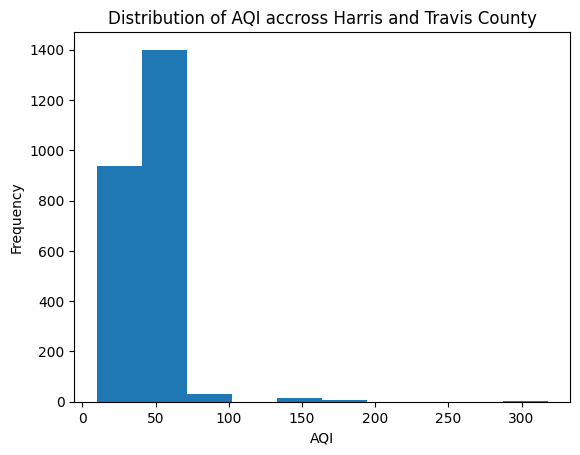

In [12]:
# Getting AQI
aqi = query_df['aqi']
mp.hist(aqi)

# Plot
mp.xlabel('AQI')
mp.ylabel('Frequency')
mp.title('Distribution of AQI accross Harris and Travis County')
mp.show()

From the plot above, we can see that the majority of our AQI data points fall close to 50. This is a good sign, because this means our air quality is moderate. However, this plot can be misleading because here might be overlapping differences between the two counties. To better understand the distribution of AQI, let's make to separate plots of each county.

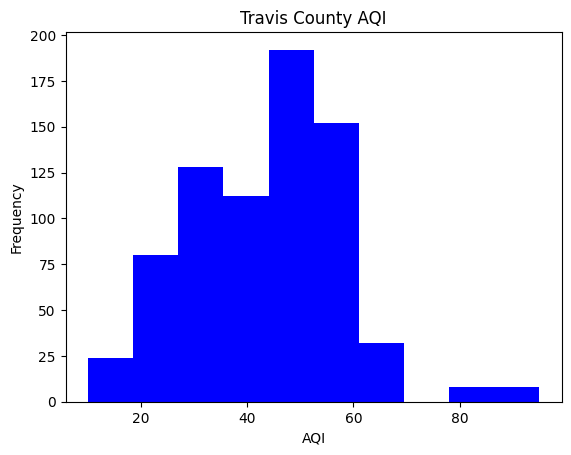

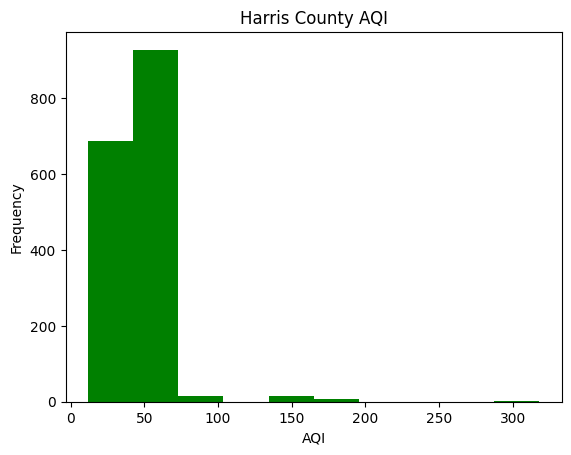

In [13]:
# Getting data for each county
travis_aqi = query_df[query_df['county'] == 'Travis']['aqi']
harris_aqi = query_df[query_df['county'] == 'Harris']['aqi']

# Plotting the two histograms
mp.figure()
mp.hist(travis_aqi, label = 'Travis', color = 'blue')
mp.xlabel('AQI')
mp.ylabel('Frequency')
mp.title('Travis County AQI')
mp.show()

mp.figure()
mp.hist(harris_aqi, label = 'Harris', color = 'green')
mp.xlabel('AQI')
mp.ylabel('Frequency')
mp.title('Harris County AQI')
mp.show()

Wow! We can see that the distribution for Harris County is on the much larger range compared to Travis County. Even though Travis County is  considered the [5th most popolous county in Texas](https://en.wikipedia.org/wiki/Travis_County,_Texas), it still releases less emissions coompared to a suburban county like Harris.

# Mean

Now, let's look at the mean of both counties to further build on this finding.

As stated earlier, the distribution of mean looks a lot better for Travis County. Most values range between 5 and 15.

On the other hand, the AQI mean for Harris County needs much more work.

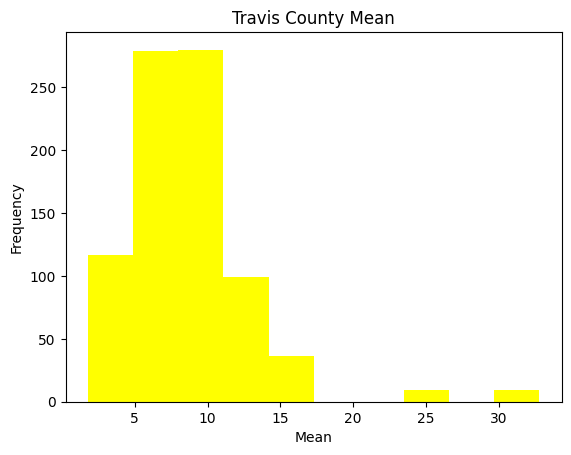

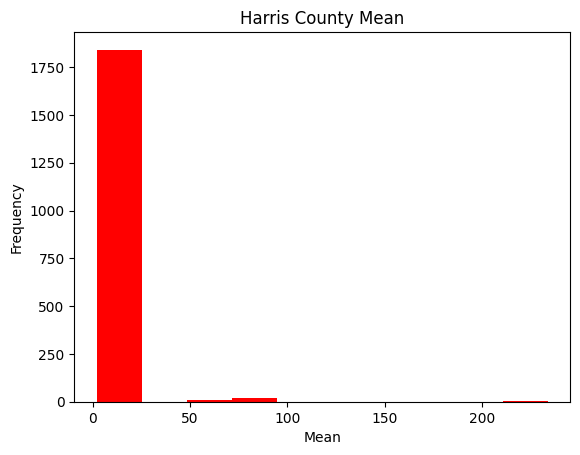

In [14]:
# Getting data for each county
travis_aqi = query_df[query_df['county'] == 'Travis']['arithmetic_mean']
harris_aqi = query_df[query_df['county'] == 'Harris']['arithmetic_mean']

# Plotting the two histograms
mp.figure()
mp.hist(travis_aqi, label = 'Travis', color = 'yellow')
mp.xlabel('Mean')
mp.ylabel('Frequency')
mp.title('Travis County Mean')
mp.show()

mp.figure()
mp.hist(harris_aqi, label = 'Harris', color = 'red')
mp.xlabel('Mean')
mp.ylabel('Frequency')
mp.title('Harris County Mean')
mp.show()

# Sample Duration

We have identified that Harris County has a worse air quality compared to Travis County, but it is also important to account for sample duration.

As it sounds, thee sample duration is the duration of the sample period, typically indicating the time over which the air quality measurement was averaged.



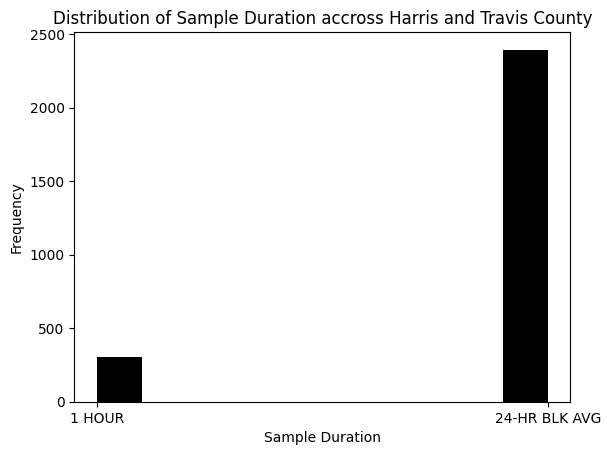

In [15]:
# Getting Sample Duration
samp_dur = query_df['sample_duration']
mp.hist(samp_dur, color = 'black')

# Plot
mp.xlabel('Sample Duration')
mp.ylabel('Frequency')
mp.title('Distribution of Sample Duration accross Harris and Travis County')
mp.show()

In our data, we have two types of samples: 1 Hour and 24 Hour. The vast majority of observations took place in the 24 Hour Block. Let's compare the 2 types of Durations.

## 1 Hour Block

After looking deeper, we see that all the values for 1 HOUR blocks are NA.  This makes our analysis a lot easier.


In [16]:
# Filtering query data
one_hr = query_df.query('sample_duration == "1 HOUR"')
print(one_hr)

      county     city        local_site_name  date_local sample_duration  \
0     Harris  Houston   Houston Bayland Park  2024-01-01          1 HOUR   
9     Harris  Houston   Houston Bayland Park  2024-01-02          1 HOUR   
18    Harris  Houston   Houston Bayland Park  2024-01-03          1 HOUR   
27    Harris  Houston   Houston Bayland Park  2024-01-04          1 HOUR   
36    Harris  Houston   Houston Bayland Park  2024-01-05          1 HOUR   
...      ...      ...                    ...         ...             ...   
2654  Travis   Austin  Austin Webberville Rd  2024-01-27          1 HOUR   
2663  Travis   Austin  Austin Webberville Rd  2024-01-28          1 HOUR   
2672  Travis   Austin  Austin Webberville Rd  2024-01-29          1 HOUR   
2681  Travis   Austin  Austin Webberville Rd  2024-01-30          1 HOUR   
2690  Travis   Austin  Austin Webberville Rd  2024-01-31          1 HOUR   

                     parameter  poc  observation_count  observation_percent  \
0     PM

# Change over time

Lastly, let's take a look aat how AQI changed over the course of January in 2024.

From the plot we can see that the AQI remains roughly constant with only a few outliers, now let's split up the two counties.

Text(0.5, 1.0, 'AQI Over Time')

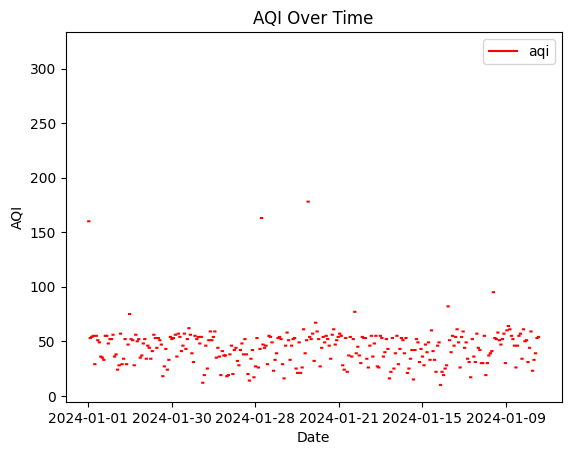

In [24]:
# Plot
query_df.plot(x = 'date_local',  y = 'aqi', color = 'red')
mp.xlabel('Date')
mp.ylabel('AQI')
mp.title('AQI Over Time')

From the plot below, we can see once again that our AQI Distribution is lower for Travis County

Text(0.5, 1.0, 'AQI Over Time - Harris County')

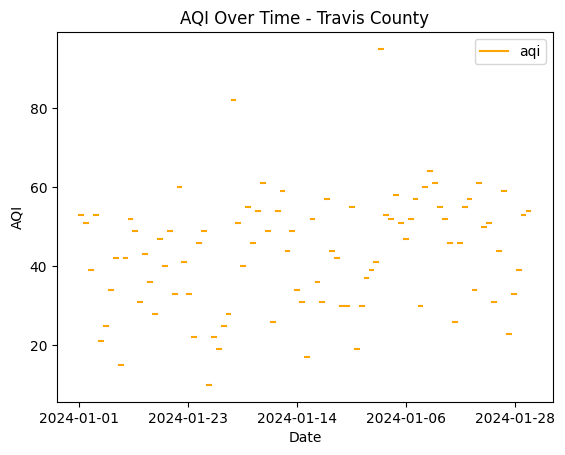

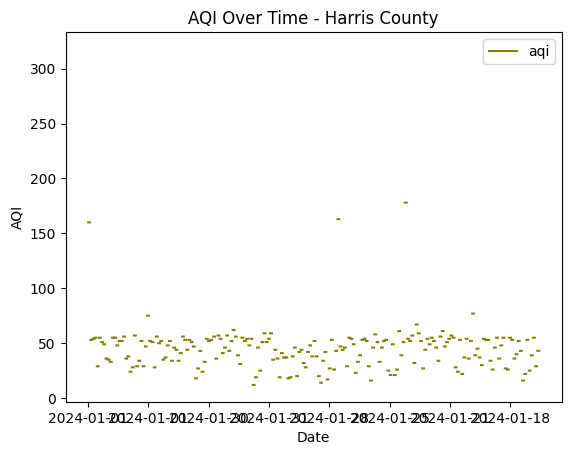

In [31]:
# Splitting counties
travis = query_df.query('county == "Travis"')
harris = query_df.query('county == "Harris"')

# Travis
travis.plot(x = 'date_local', y = 'aqi', color = 'orange')
mp.xlabel('Date')
mp.ylabel('AQI')
mp.title('AQI Over Time - Travis County')

# Harris
harris.plot(x = 'date_local', y = 'aqi', color = 'olive')
mp.xlabel('Date')
mp.ylabel('AQI')
mp.title('AQI Over Time - Harris County')

# Conclusion

After analysis, we can conclude:



*   Travis County had better AQI over the course of January 2024
*   There were no 1 Hour samples in our data

I learned from this analysis that despite the bad rhetoric, big cities can have better air quality than suburban areas. One reason for this is because suburbs release more carbon emissions per capita compared to big cities. The reasons for this are:



*   Big Cities have laws and policy that aim to reduce carbon footprints
*   In big cities places are close by, so there is no need for cars, and people tend to use public transportation

Overall, this project was really helpful in understanding the distribution of AQI across suburban and urban forms of living.



